1. DATA LOAD

In [ ]:
# 1. 기존 폴더 완전히 삭제
!rm -rf /content/bdd100k_night
!rm -rf /content/bdd_night_test
!rm -rf /content/bdd_night_final

print("✅ 모든 데이터가 초기화되었습니다. 다시 압축을 풀어주세요.")

✅ 모든 데이터가 초기화되었습니다. 다시 압축을 풀어주세요.


In [ ]:
from google.colab import drive
import os

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. ZIP 파일 경로 설정 (본인의 실제 경로로 수정하세요)
zip_path = '/content/drive/MyDrive/bdd100k-finetune.v3-bdd100k-night-v3.coco.zip'
target_dir = '/content/bdd100k_night'

# 3. 압축 해제
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    !unzip -q "{zip_path}" -d "{target_dir}"
    print("압축 해제 완료!")

Mounted at /content/drive
압축 해제 완료!


2. DATASET 시각화

[TRAIN] 이미지: 27445장, 박스 개수: 361859개


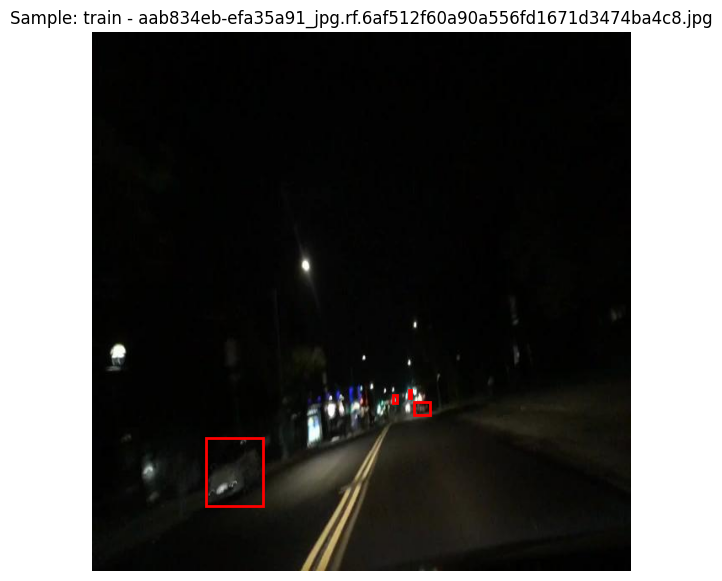

[VALID] 이미지: 4394장, 박스 개수: 58316개


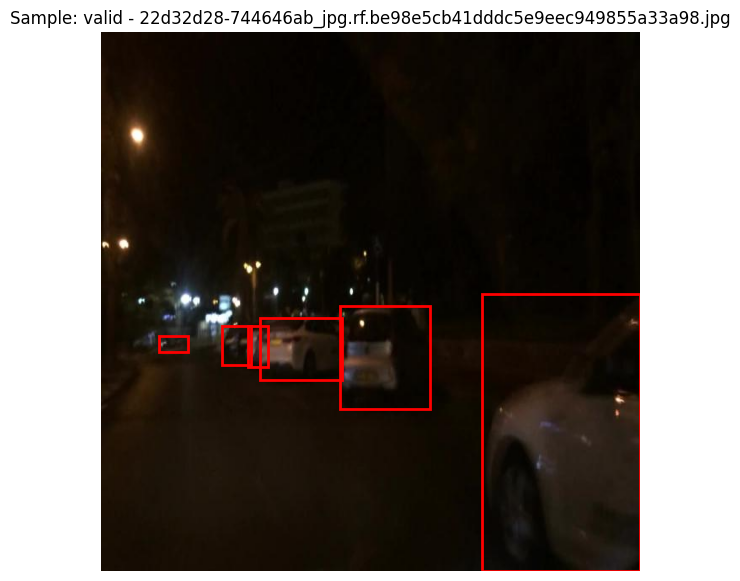

[TEST] 이미지: 60장, 박스 개수: 881개


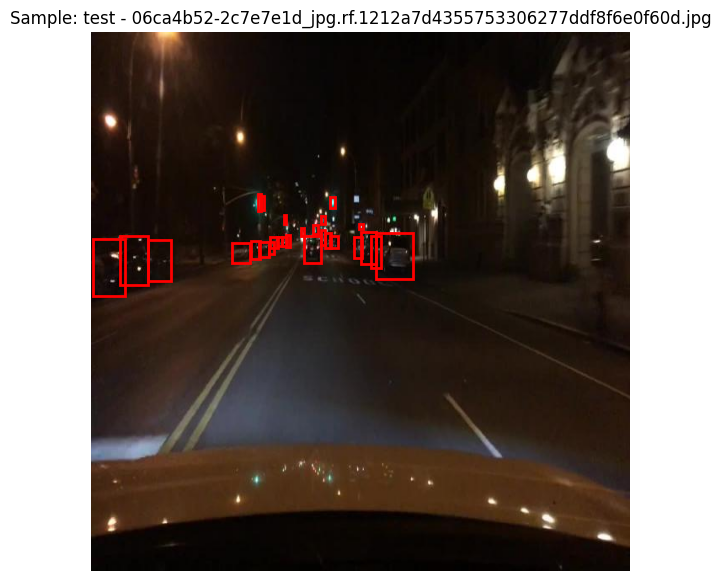

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def check_and_visualize(base_path, split_name):
    # 1. 경로 설정 (폴더명이 valid인지 val인지 확인 필요)
    split_path = os.path.join(base_path, split_name)
    ann_path = os.path.join(split_path, "_annotations.coco.json")

    if not os.path.exists(ann_path):
        print(f"경로를 찾을 수 없습니다: {ann_path}")
        return

    # 2. JSON 데이터 로드
    with open(ann_path, 'r') as f:
        data = json.load(f)

    # 3. 이미지 개수 출력
    num_images = len(data['images'])
    num_anns = len(data['annotations'])
    print(f"[{split_name.upper()}] 이미지: {num_images}장, 박스 개수: {num_anns}개")

    # 4. 랜덤 샘플 시각화 (좌표 변환 없이 원본 그대로)
    sample_img_info = random.choice(data['images'])
    img_id = sample_img_info['id']
    img_name = sample_img_info['file_name']

    # 이미지 불러오기
    img_path = os.path.join(split_path, img_name)
    img = Image.open(img_path)

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    ax = plt.gca()

    # 해당 이미지의 박스(annotations)만 찾아서 그리기
    for ann in data['annotations']:
        if ann['image_id'] == img_id:
            # COCO 원본 좌표: [x_min, y_min, width, height]
            x, y, w, h = ann['bbox']

            # 박스 그리기 (변환 없이 원본 좌표 사용)
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.title(f"Sample: {split_name} - {img_name}")
    plt.axis('off')
    plt.show()

# --- 실행 부분 ---
root_path = '/content/bdd100k_night'

# 폴더명이 다를 수 있으니 리스트를 확인하세요
for s in ['train', 'valid', 'test']:
    check_and_visualize(root_path, s)

Real-esrgan

In [ ]:
pip install basicsr
pip install realesrgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.7 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214816 sha256=a9b573b012c9c2c56b535b18ec07c360e1f180ee68e11be04c162d10980896b3
  Stored in directory: /root/.cache/pip/wheels/9a/e3/e4/58f29bfabb622dd40b6d9839318ce5bf092062b81ca3aa19ea
Successfully built basicsr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.6 MB/s eta 0:

In [ ]:
import os
import shutil
import cv2
import torch
import json
from tqdm import tqdm
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet

# ==========================================
# 1. ESRGAN 모델 설정 및 초기화
# ==========================================
def tqdm_esrgan_setup(model_path):
    model = RRDBNet(
        num_in_ch=3,
        num_out_ch=3,
        num_feat=64,
        num_block=23,
        num_grow_ch=32,
        scale=4
    )

    upsampler = RealESRGANer(
        scale=4,
        model_path=model_path,
        model=model,
        tile=256,
        tile_pad=10,
        pre_pad=0,
        half=True if torch.cuda.is_available() else False
    )

    return upsampler


# ==========================================
# 2. 개별 이미지 강화 함수
# ==========================================
def enhance_night_image(upsampler, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {img_path}")

    output, _ = upsampler.enhance(img, outscale=2)
    return output


# ==========================================
# 3. 데이터셋 구조 생성 및 업샘플링 실행
# ==========================================
def create_upsampled_dataset(upsampler, base_path, save_path, splits=['test', 'valid']):
    for split in splits:
        print(f"\n🚀 [{split}] 데이터셋 고화질 변환 시작...")

        src_img_dir = os.path.join(base_path, split, 'images')
        src_lbl_dir = os.path.join(base_path, split, 'labels')

        dst_img_dir = os.path.join(save_path, split, 'images')
        dst_lbl_dir = os.path.join(save_path, split, 'labels')

        os.makedirs(dst_img_dir, exist_ok=True)
        os.makedirs(dst_lbl_dir, exist_ok=True)

        if os.path.exists(src_img_dir):
            img_list = [
                f for f in os.listdir(src_img_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            for img_name in tqdm(img_list, desc=f"🖼️ Upsampling {split} images"):
                input_path = os.path.join(src_img_dir, img_name)
                output_path = os.path.join(dst_img_dir, img_name)

                if os.path.exists(output_path):
                    continue

                try:
                    enhanced_img = enhance_night_image(upsampler, input_path)
                    cv2.imwrite(output_path, enhanced_img)
                except Exception as e:
                    print(f"\n❌ {img_name} 변환 실패: {e}")
                    continue

        if os.path.exists(src_lbl_dir):
            lbl_list = [f for f in os.listdir(src_lbl_dir) if f.endswith('.txt')]

            for lbl_name in tqdm(lbl_list, desc=f"🏷️ Copying {split} labels"):
                src_lbl_path = os.path.join(src_lbl_dir, lbl_name)
                dst_lbl_path = os.path.join(dst_lbl_dir, lbl_name)

                if not os.path.exists(dst_lbl_path):
                    shutil.copy2(src_lbl_path, dst_lbl_path)

    print(f"\n✨ 모든 작업이 완료되었습니다!")
    print(f"📍 저장 위치: {save_path}")


# ==========================================
# 4. 실행 (Main)
# ==========================================
if __name__ == "__main__":
    MODEL_PATH = '/content/RealESRGAN_x4plus.pth'

    upsampler = tqdm_esrgan_setup(MODEL_PATH)

    SOURCE_PATH = '/content/bdd100k_night'
    TARGET_PATH = '/content/bdd100k_night_upsampled'

    create_upsampled_dataset(
        upsampler=upsampler,
        base_path=SOURCE_PATH,
        save_path=TARGET_PATH,
        splits=['train', 'valid', 'test']
    )



🚀 [train] 데이터셋 고화질 변환 시작...


🏷️ Copying train labels: 100%|██████████| 27326/27326 [00:00<00:00, 186695.91it/s]



🚀 [valid] 데이터셋 고화질 변환 시작...


🏷️ Copying valid labels: 100%|██████████| 4373/4373 [00:00<00:00, 187133.38it/s]



🚀 [test] 데이터셋 고화질 변환 시작...


🏷️ Copying test labels: 100%|██████████| 60/60 [00:00<00:00, 69136.88it/s]


✨ 모든 작업이 완료되었습니다!
📍 저장 위치: /content/bdd100k_night_upsampled


In [ ]:
import os
import yaml
from tqdm import tqdm

# 1. 경로 설정 (업샘플링된 데이터셋 경로를 넣으세요)
# 만약 구글 드라이브라면: '/content/drive/MyDrive/bdd100k_night_upsampled'
TARGET_DATASET_PATH = '/content/bdd100k_night_upsampled'

# 수정할 라벨 폴더들
splits = ['train', 'valid', 'test']

# 2. 매핑 정보
vehicle_ids = [11, 12, 13, 14, 22]  # bike, bus, car, motor, truck
pedestrian_ids = [15, 16]           # person, rider

print(f"🚀 [{TARGET_DATASET_PATH}] 라벨 수정 및 매핑 시작...")

for split in splits:
    lbl_dir = os.path.join(TARGET_DATASET_PATH, split, 'labels')

    if not os.path.exists(lbl_dir):
        print(f"⚠️ {split} 폴더에 labels가 없습니다. 건너뜁니다.")
        continue

    # 폴더 내 모든 .txt 파일 처리
    label_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]

    for label_file in tqdm(label_files, desc=f"Mapping {split} labels"):
        file_path = os.path.join(lbl_dir, label_file)
        new_lines = []

        with open(file_path, 'r') as f:
            for line in f:
                parts = line.split()
                if not parts: continue

                class_id = int(parts[0])

                # --- 매핑 로직 ---
                if class_id in vehicle_ids:
                    new_id = 0  # Vehicle
                elif class_id in pedestrian_ids:
                    new_id = 1  # Pedestrian
                else:
                    # 기차(21)나 다른 클래스는 학습에서 제외
                    continue

                new_lines.append(f"{new_id} {' '.join(parts[1:])}\n")

        # 기존 파일을 수정된 내용으로 덮어쓰기
        with open(file_path, 'w') as f:
            f.writelines(new_lines)

print("✅ 모든 라벨 수정 완료! (Vehicle: 0, Pedestrian: 1)")

# 3. 새로운 data.yaml 생성
data_config = {
    'path': TARGET_DATASET_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['Vehicle', 'Pedestrian']
}

yaml_save_path = os.path.join(TARGET_DATASET_PATH, 'data.yaml')
with open(yaml_save_path, 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print(f"✅ 새로운 data.yaml 생성 완료! 위치: {yaml_save_path}")

🚀 [/content/bdd100k_night_upsampled] 라벨 수정 및 매핑 시작...


Mapping test labels: 100%|██████████| 60/60 [00:00<00:00, 8667.41it/s]

✅ 모든 라벨 수정 완료! (Vehicle: 0, Pedestrian: 1)
✅ 새로운 data.yaml 생성 완료! 위치: /content/bdd100k_night_upsampled/data.yaml


In [ ]:
import yaml
import os
from ultralytics import YOLO

# 1. 경로 설정 (기존과 동일)
target_path = '/content/bdd100k_night_upsampled'

data_config = {
    'path': target_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['Vehicle', 'Pedestrian']
}

# yaml 저장
os.makedirs(target_path, exist_ok=True)
yaml_path = os.path.join(target_path, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

# 2. 모델 로드
# .yaml 파일 없이 .pt 파일만 넣으면 표준 아키텍처를 사용합니다.
model = YOLO('yolo11s.pt')

# 3. 학습 시작
model.train(
    data=yaml_path,
    epochs=20,
    imgsz=1280,            # 업샘플링된 이미지의 이점을 살리기 위해 1280 유지
    batch=16,              # P2를 뺐으므로 배치를 더 크게 잡을 수 있어 속도가 빨라집니다.
    device=0,
    optimizer='AdamW',
    project='/content/drive/MyDrive/YOLOv11_Night_SR',
    name='bdd100k_standard_1280', # 이름 변경
    exist_ok=True,
    cache=True,
    workers=4,
)

New https://pypi.org/project/ultralytics/8.4.0 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bdd100k_night_upsampled/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bdd100k_standar

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d4ae1cf99a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

📊 학습 지표 분석 경로: /content/drive/MyDrive/YOLOv11_Night_SR/bdd100k_standard_1280


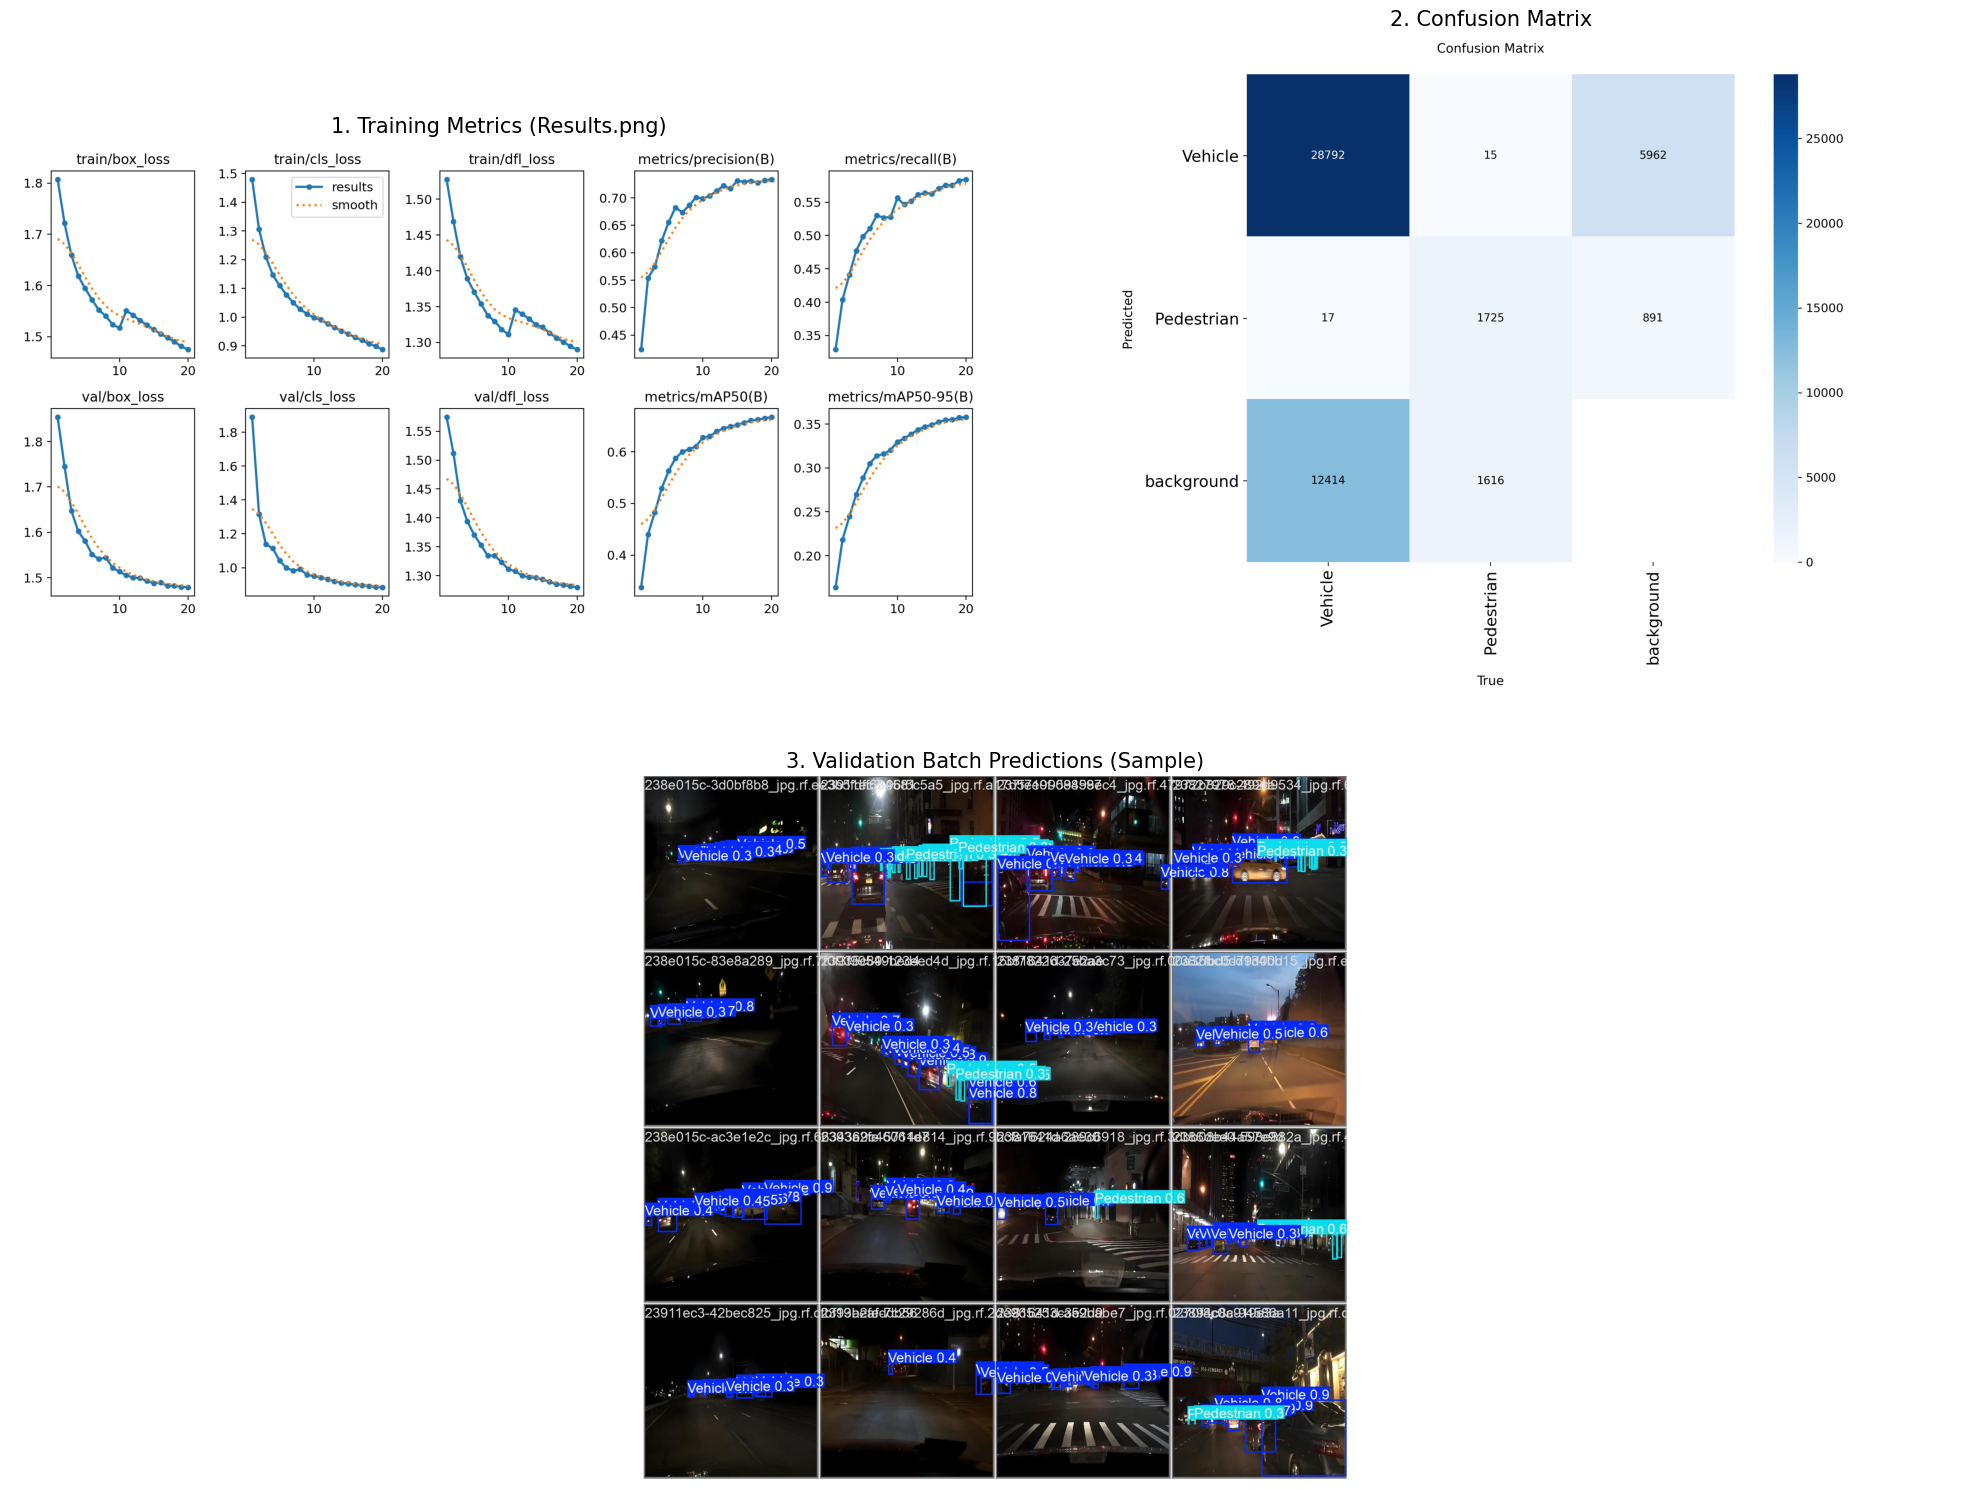

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# ==========================================
# 1. 경로 설정
# ==========================================
# 학습 결과가 저장된 구글 드라이브 경로
project_path = '/content/drive/MyDrive/YOLOv11_Night_SR/bdd100k_standard_1280'

print(f"📊 학습 지표 분석 경로: {project_path}")

# ==========================================
# 2. 결과 시각화 (그래프 및 검증 이미지)
# ==========================================
fig = plt.figure(figsize=(20, 15))

# (1) 학습 결과 요약 그래프 (Loss, Precision, Recall, mAP 등)
# 학습이 진행됨에 따라 오차가 줄어들고 정확도가 오르는지 확인합니다.
if os.path.exists(os.path.join(project_path, 'results.png')):
    plt.subplot(2, 2, 1)
    results_img = cv2.imread(os.path.join(project_path, 'results.png'))
    plt.imshow(cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB))
    plt.title("1. Training Metrics (Results.png)", fontsize=15)
    plt.axis('off')
else:
    print("⚠️ 'results.png' 파일을 찾을 수 없습니다.")

# (2) 혼동 행렬 (Confusion Matrix)
# 모델이 Vehicle과 Pedestrian을 서로 헷갈려하는지 확인합니다.
if os.path.exists(os.path.join(project_path, 'confusion_matrix.png')):
    plt.subplot(2, 2, 2)
    cm_img = cv2.imread(os.path.join(project_path, 'confusion_matrix.png'))
    plt.imshow(cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB))
    plt.title("2. Confusion Matrix", fontsize=15)
    plt.axis('off')
else:
    print("⚠️ 'confusion_matrix.png' 파일을 찾을 수 없습니다.")

# (3) 검증 데이터 실제 예측 샘플 (Validation Predictions)
# 학습 도중 모델이 검증 세트의 야간 고화질 이미지를 실제로 어떻게 예측했는지 보여줍니다.
if os.path.exists(os.path.join(project_path, 'val_batch0_pred.jpg')):
    plt.subplot(2, 1, 2)
    val_pred_img = cv2.imread(os.path.join(project_path, 'val_batch0_pred.jpg'))
    plt.imshow(cv2.cvtColor(val_pred_img, cv2.COLOR_BGR2RGB))
    plt.title("3. Validation Batch Predictions (Sample)", fontsize=15)
    plt.axis('off')
else:
    print("⚠️ 'val_batch0_pred.jpg' 파일을 찾을 수 없습니다.")

plt.tight_layout()
plt.show()

In [ ]:
from ultralytics import YOLO
import os

# ==========================================
# 1. 경로 설정
# ==========================================
# 학습된 최적 가중치 경로
model_path = '/content/drive/MyDrive/YOLOv11_Night_SR/bdd100k_standard_1280/weights/best.pt'
# 데이터 설정 파일 경로
yaml_path = '/content/bdd100k_night_upsampled/data.yaml'

# ==========================================
# 2. 모델 로드 및 검증(Validation) 실행
# ==========================================
model = YOLO(model_path)

# split='test' 옵션을 통해 val 데이터가 아닌 test 데이터를 사용합니다.
results = model.val(
    data=yaml_path,
    split='test',      # test 세트로 검증 수행
    imgsz=1280,        # 학습 시 사용한 해상도 유지
    batch=16,
    device=0,          # GPU 사용
    save_json=True     # 상세 분석을 위해 json 결과 저장
)

# ==========================================
# 3. 주요 성능 지표 출력
# ==========================================
print("\n" + "="*30)
print(f"🚀 [Test Set 검증 결과]")
print(f"정확도(Precision): {results.results_dict['metrics/precision(B)']:.4f}")
print(f"재현율(Recall): {results.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP50: {results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")
print("="*30)

Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 56.7±9.6 MB/s, size: 205.7 KB)
val: Scanning /content/bdd100k_night_upsampled/test/labels... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 430.0it/s 0.1s
val: New cache created: /content/bdd100k_night_upsampled/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.0it/s 3.8s
                   all         60        649      0.822      0.614      0.715        0.4
               Vehicle         60        635      0.835      0.622       0.77      0.439
            Pedestrian          9         14      0.809      0.606      0.661       0.36
Speed: 14.0ms preprocess, 9.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Saving /content/runs/detect/val/predictions.json...

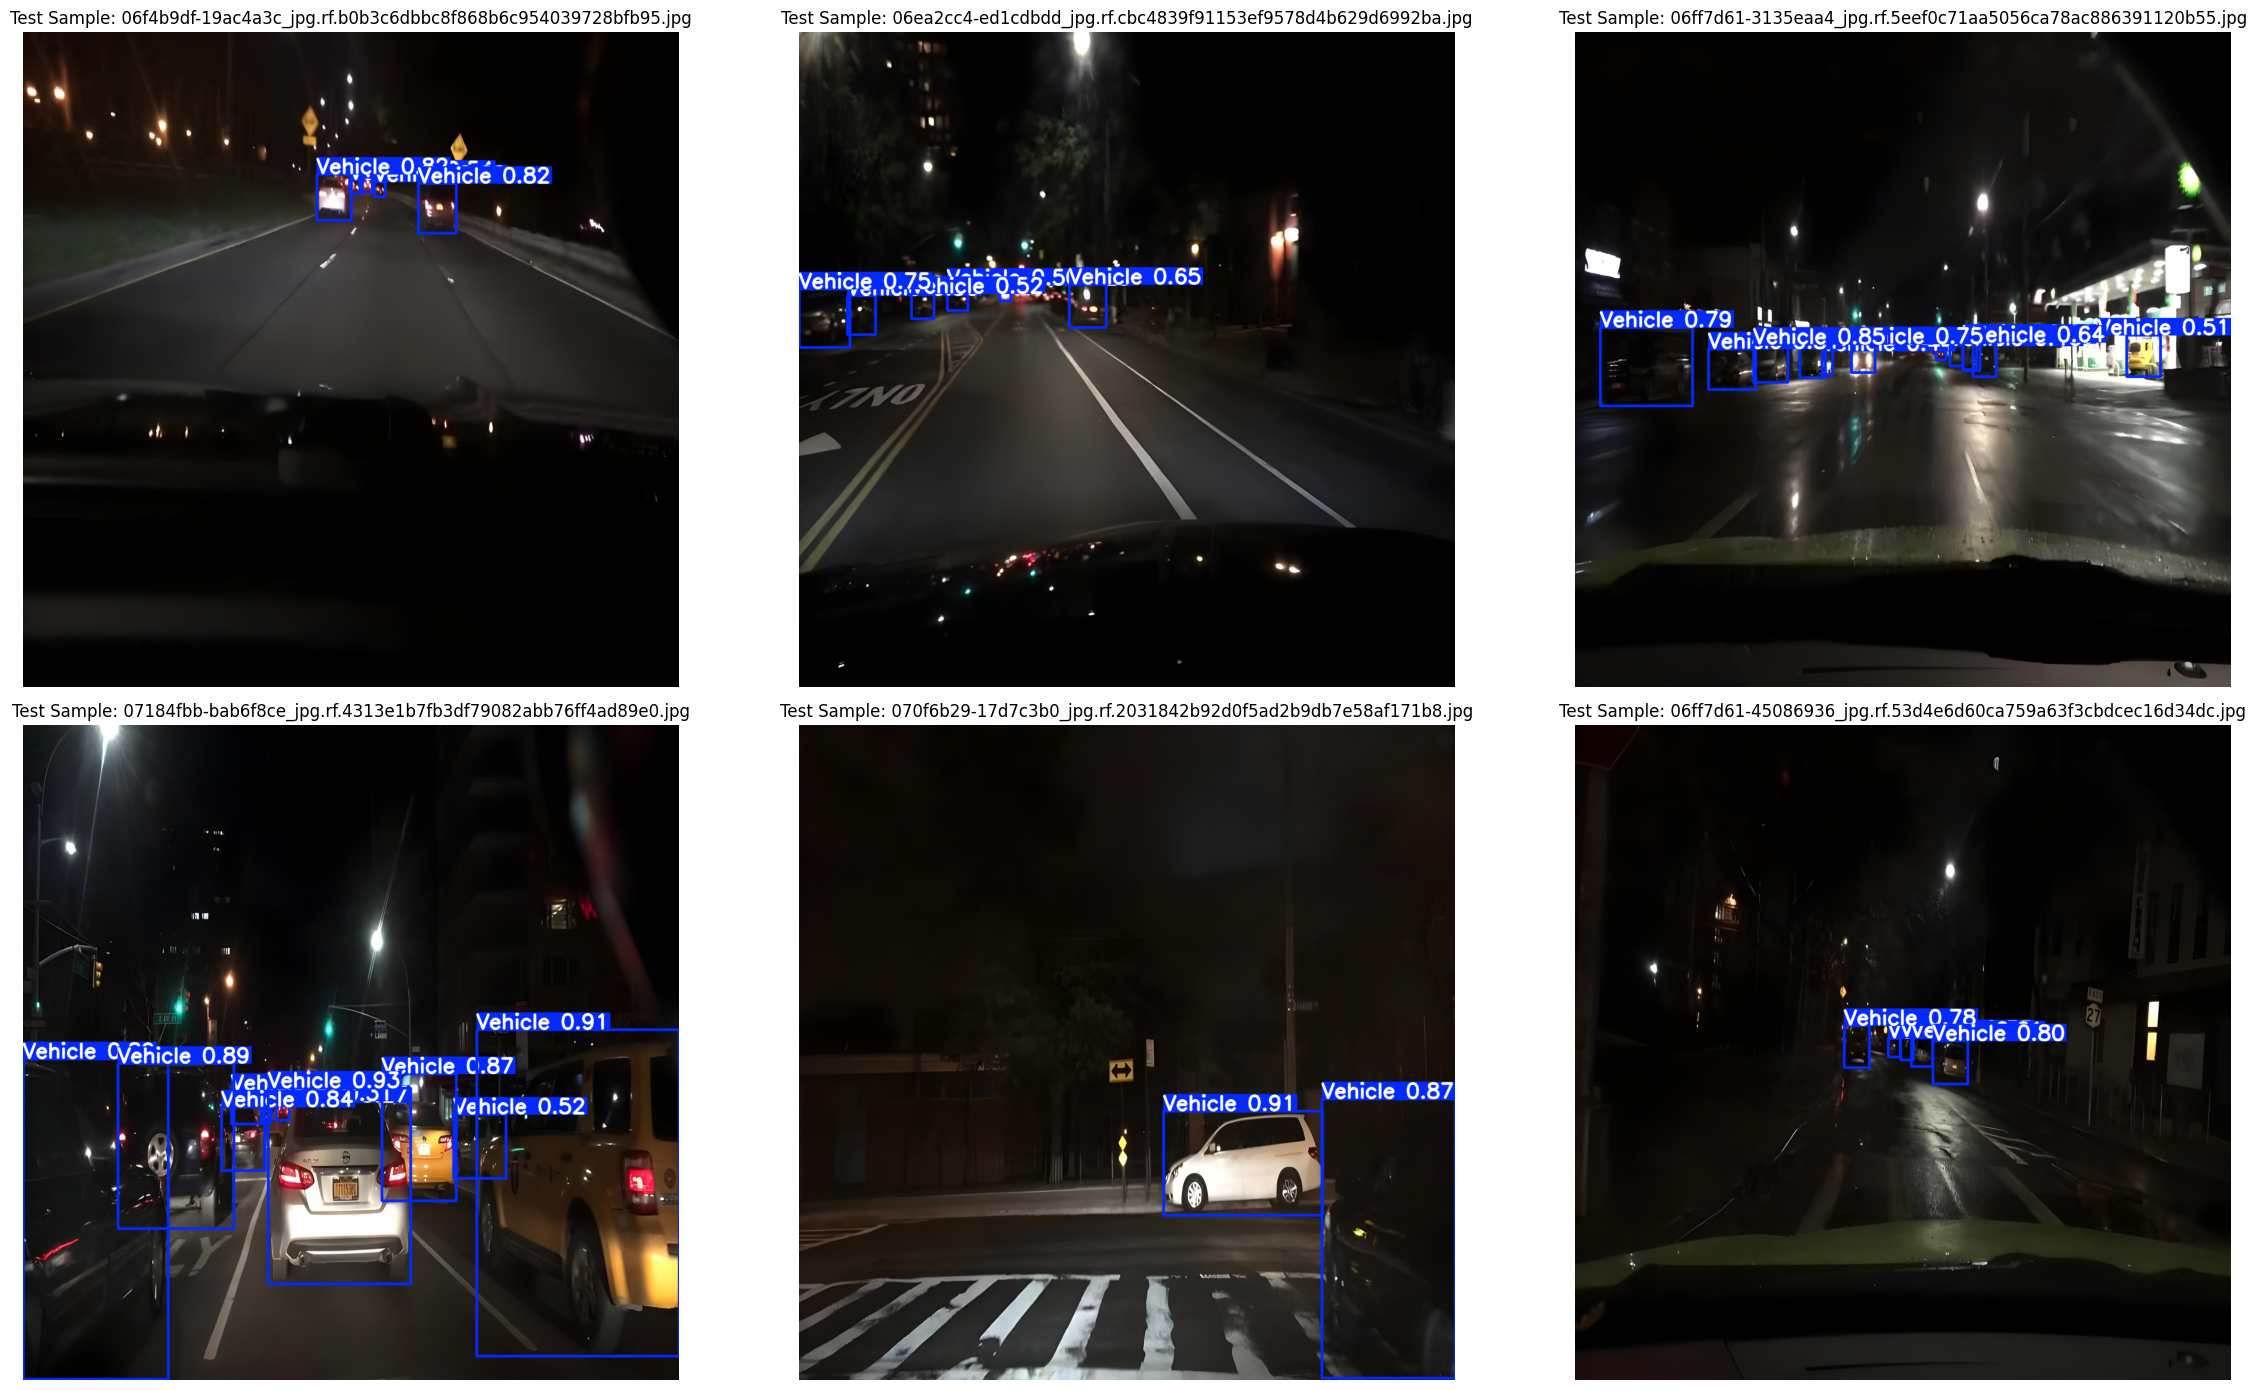

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==========================================
# 1. 경로 및 모델 설정
# ==========================================
model_path = '/content/drive/MyDrive/YOLOv11_Night_SR/bdd100k_standard_1280/weights/best.pt'
test_img_dir = '/content/bdd100k_night_upsampled/test/images'

# 모델 로드
model = YOLO(model_path)

# ==========================================
# 2. 테스트 이미지 랜덤 샘플링 (예: 6장)
# ==========================================
num_samples = 6
all_test_images = [f for f in os.listdir(test_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_images = random.sample(all_test_images, num_samples)

# ==========================================
# 3. 추론 및 시각화 (2x3 격자)
# ==========================================
plt.figure(figsize=(24, 14))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(test_img_dir, img_name)

    # 모델 추론 (conf: 신뢰도 임계값, imgsz: 학습 시 해상도)
    results = model.predict(source=img_path, conf=0.25, imgsz=1280, verbose=False)

    # 결과 이미지 렌더링 (BBox와 라벨이 그려진 이미지 추출)
    res_plotted = results[0].plot()
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    # 시각화 배치
    plt.subplot(2, 3, i + 1)
    plt.imshow(res_rgb)
    plt.title(f"Test Sample: {img_name}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


📍 오탐 발견: 07184fbb-af89b759_jpg.rf.d84a98f9737717d836e3f716b12acee6.jpg (Green: 정답, Red: 오탐)


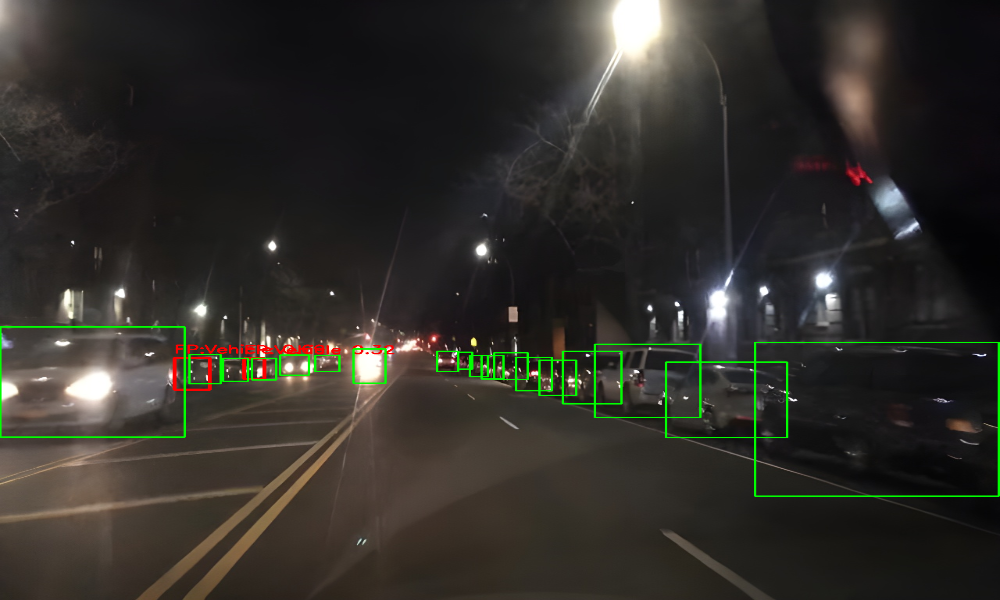


📍 오탐 발견: 06eba8d5-65737473_jpg.rf.7073ac37bc95d886b2d29a1179b27abd.jpg (Green: 정답, Red: 오탐)


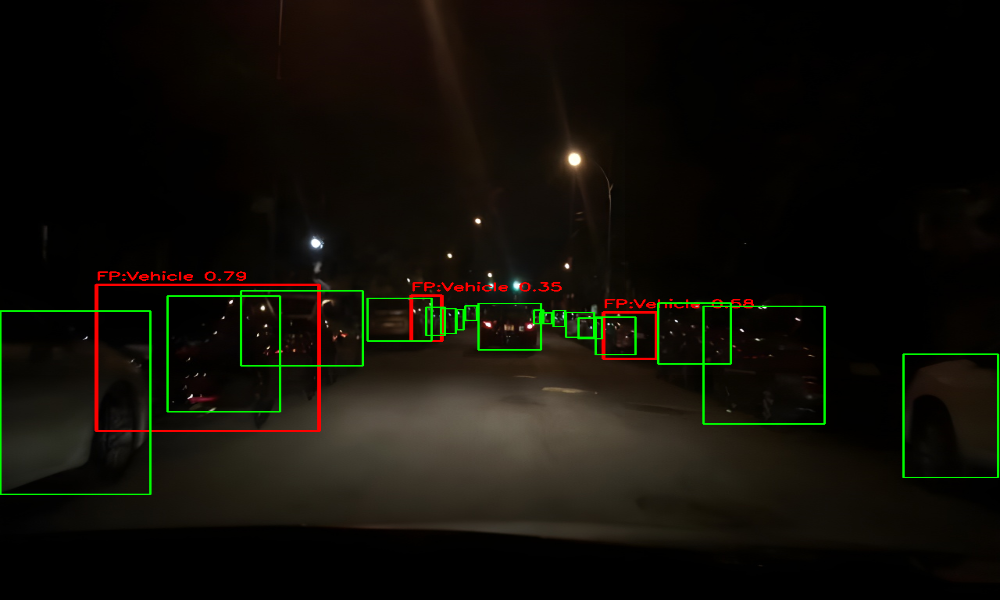


📍 오탐 발견: 0711ab13-e486593d_jpg.rf.5a374f92341b262fcd83549e857432f0.jpg (Green: 정답, Red: 오탐)


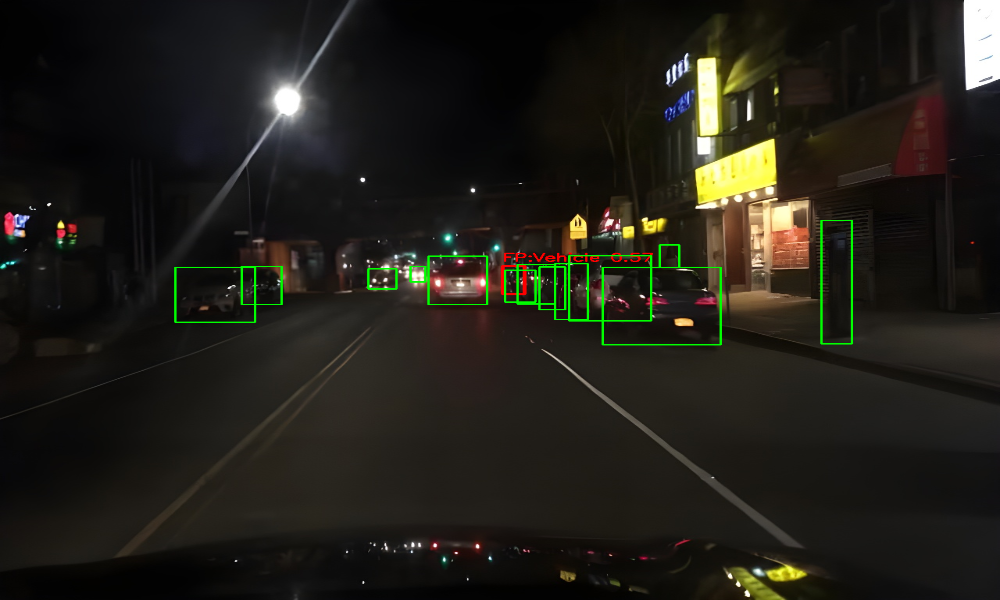

In [ ]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# ==========================================
# 1. 경로 설정 및 함수 정의
# ==========================================
model_path = '/content/drive/MyDrive/YOLOv11_Night_SR/bdd100k_standard_1280/weights/best.pt'
test_img_dir = '/content/bdd100k_night_upsampled/test/images'
test_lbl_dir = '/content/bdd100k_night_upsampled/test/labels'

model = YOLO(model_path)

def calculate_iou(box1, box2):
    """Intersection over Union (IoU) 계산"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # 좌상단, 우하단 좌표로 변환
    b1_x1, b1_y1, b1_x2, b1_y2 = x1-w1/2, y1-h1/2, x1+w1/2, y1+h1/2
    b2_x1, b2_y1, b2_x2, b2_y2 = x2-w2/2, y2-h2/2, x2+w2/2, y2+h2/2

    inter_x1 = max(b1_x1, b2_x1)
    inter_y1 = max(b1_y1, b2_y1)
    inter_x2 = min(b1_x2, b2_x2)
    inter_y2 = min(b1_y2, b2_y2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)

# ==========================================
# 2. 오탐(FP) 이미지 검색 및 시각화
# ==========================================
def visualize_false_positives(num_samples=3, iou_threshold=0.45):
    all_test_imgs = [f for f in os.listdir(test_img_dir) if f.endswith('.jpg')]
    random.shuffle(all_test_imgs)

    found_count = 0

    for img_name in all_test_imgs:
        if found_count >= num_samples: break

        img_path = os.path.join(test_img_dir, img_name)
        lbl_path = os.path.join(test_lbl_dir, img_name.replace('.jpg', '.txt'))

        if not os.path.exists(lbl_path): continue

        # 1. 정답(GT) 로드
        gt_boxes = []
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.split()))
                gt_boxes.append(parts) # [cls, x, y, w, h]

        # 2. 모델 예측
        results = model.predict(source=img_path, conf=0.3, imgsz=1280, verbose=False)
        pred_boxes = results[0].boxes.data.cpu().numpy() # [x1, y1, x2, y2, conf, cls]

        img_cv = cv2.imread(img_path)
        h, w, _ = img_cv.shape
        fp_detected = False

        # 3. 오탐(FP) 판별
        # 예측된 박스 중 GT와 IoU가 낮은 것들을 찾음
        for pred in pred_boxes:
            px1, py1, px2, py2, pconf, pcls = pred
            # YOLO xyxy -> 정규화된 xywh로 변환 (IoU 계산용)
            pw, ph = (px2 - px1) / w, (py2 - py1) / h
            pxc, pyc = (px1 / w) + pw/2, (py1 / h) + ph/2

            is_fp = True
            for gt in gt_boxes:
                if pcls == gt[0]: # 같은 클래스인 경우 IoU 체크
                    iou = calculate_iou([pxc, pyc, pw, ph], gt[1:])
                    if iou > iou_threshold:
                        is_fp = False
                        break

            if is_fp: # 오탐 발견!
                fp_detected = True
                # 빨간색 박스로 오탐 표시 (FP)
                cv2.rectangle(img_cv, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), 3)
                cv2.putText(img_cv, f"FP:{model.names[int(pcls)]} {pconf:.2f}",
                            (int(px1), int(py1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # 정답(GT)도 녹색 박스로 함께 표시하여 비교
        for gt in gt_boxes:
            gcls, gx, gy, gw, gh = gt
            gx1, gy1 = int((gx - gw/2) * w), int((gy - gh/2) * h)
            gx2, gy2 = int((gx + gw/2) * w), int((gy + gh/2) * h)
            cv2.rectangle(img_cv, (gx1, gy1), (gx2, gy2), (0, 255, 0), 2)

        if fp_detected:
            print(f"\n📍 오탐 발견: {img_name} (Green: 정답, Red: 오탐)")
            cv2_imshow(cv2.resize(img_cv, (1000, 600)))
            found_count += 1

visualize_false_positives(num_samples=3)

3. --------------------------------------------

In [ ]:
!pip install -q ultralytics
import os
import json
import shutil
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.6 MB/s eta 0:00:00
